In [1]:
import tensorflow as tf
import cv2
import os
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV3Large
from sklearn.model_selection import train_test_split

In [ ]:
# Function to load data from a given directory
def load_data(data_dir):
    images = []
    labels = []
    class_names = os.listdir(data_dir)  # Get class names from folder names
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))  # Resize to match model input size
            images.append(img)
            labels.append(label)
    images = np.array(images) / 255.0  # Normalize pixel values
    labels = np.array(labels)
    return images, labels, class_names

In [3]:
# Paths to the train and test folders
train_dir = r"C:\Users\Auni\Documents\SEM8\SECJ4134_SOFTWARE_ENGINEERING_PROJECT_II\FER2013\train"
test_dir = r"C:\Users\Auni\Documents\SEM8\SECJ4134_SOFTWARE_ENGINEERING_PROJECT_II\FER2013\test"

In [10]:
Classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

In [11]:
img_size = 224

In [12]:
# Function to load and preprocess images
def load_and_preprocess_image(image_path, label):
    # Read the image file
    img = tf.io.read_file(image_path)
    
    # Decode the image as an RGB image
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    
    # Resize the image to the target size
    img = tf.image.resize(img, [img_size, img_size])
    
    # Normalize the image to [0, 1]
    img = img / 255.0
    
    return img, label

In [13]:
# Split the dataset into training and testing sets
image_paths = []
labels = []

In [14]:
for class_name in Classes:
    class_dir = os.path.join(Datadirectory, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)

        # Check if it's a file and has a valid image extension
        if os.path.isfile(img_path) and img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(img_path)
            labels.append(Classes.index(class_name))

In [15]:
# Split into training and testing sets (80% train, 20% test)
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [16]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

In [17]:
# Apply preprocessing
train_dataset = train_dataset.map(lambda image_path, label: load_and_preprocess_image(image_path, label), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda image_path, label: load_and_preprocess_image(image_path, label), num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
# Batch and prefetch
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [19]:
# Model building
input_layer = keras.Input(shape=(img_size, img_size, 3))
model = MobileNetV3Large(weights='imagenet', input_tensor=input_layer, include_top=False)

In [22]:
#model building
input_layer = keras.Input(shape=(img_size, img_size, 3))

In [23]:
input_layer.shape

(None, 224, 224, 3)

In [24]:
model.summary()

Model: "MobileNetV3Large"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 2,971,952 (11.34 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [25]:
base_input = model.input

In [26]:
base_output = model.output

In [27]:
base_output = layers.GlobalAveragePooling2D()(base_output)

In [28]:
base_output

<KerasTensor shape=(None, 960), dtype=float32, sparse=False, ragged=False, name=keras_tensor_205>

In [29]:
final_output = layers.Dense(128)(base_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation='softmax')(final_output)

In [30]:
final_output

<KerasTensor shape=(None, 7), dtype=float32, sparse=False, ragged=False, name=keras_tensor_210>

In [31]:
new_model = keras.Model(inputs=base_input, outputs=final_output)

In [32]:
new_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,128,071 (11.93 MB)

 Trainable params: 3,103,671 (11.84 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [33]:
# # Inspect dataset structure
# for element in dataset.take(1):
#     print(element)

#     output:
#     (<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
# array([[[[0.19215687, 0.19215687, 0.19215687],
#          [0.19215687, 0.19215687, 0.19215687],
#          [0.1894958 , 0.1894958 , 0.1894958 ],
#          ...,
#          [0.3619045 , 0.3619045 , 0.3619045 ],
#          [0.3529412 , 0.3529412 , 0.3529412 ],
#          [0.3529412 , 0.3529412 , 0.3529412 ]],

#         [[0.19215687, 0.19215687, 0.19215687],
#          [0.19215687, 0.19215687, 0.19215687],
#          [0.1894958 , 0.1894958 , 0.1894958 ],
#          ...,
#          [0.3619045 , 0.3619045 , 0.3619045 ],
#          [0.3529412 , 0.3529412 , 0.3529412 ],
#          [0.3529412 , 0.3529412 , 0.3529412 ]],

#         [[0.19313726, 0.19313726, 0.19313726],
#          [0.19313726, 0.19313726, 0.19313726],
#          [0.1904562 , 0.1904562 , 0.1904562 ],
#          ...,
#          [0.3621746 , 0.3621746 , 0.3621746 ],
#          [0.35322127, 0.35322127, 0.35322127],
#          [0.35322127, 0.35322127, 0.35322127]],
# ...
#          [0.05882353, 0.05882353, 0.05882353],
#          [0.05882353, 0.05882353, 0.05882353]]]], dtype=float32)>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
# array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>)

In [34]:
# Compile and train the model
new_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
#new_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#This warning indicates that there is a mismatch between the number of variables in the optimizer saved in the model file and the optimizer in the current environment. Specifically:
#The saved optimizer (rmsprop) in the model file has 354 variables.
#The current optimizer in your environment has 178 variables.

In [35]:
history = new_model.fit(train_dataset, epochs=15)

Epoch 1/15


c:\Users\Auni\anaconda3\envs\tf-gpu\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


718/718 ━━━━━━━━━━━━━━━━━━━━ 601s 800ms/step - accuracy: 0.4847 - loss: 1.3428
Epoch 2/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 594s 828ms/step - accuracy: 0.6192 - loss: 1.0171
Epoch 3/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 591s 823ms/step - accuracy: 0.6732 - loss: 0.8787
Epoch 4/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 584s 813ms/step - accuracy: 0.7167 - loss: 0.7666
Epoch 5/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 566s 789ms/step - accuracy: 0.7567 - loss: 0.6588
Epoch 6/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 585s 815ms/step - accuracy: 0.7862 - loss: 0.5847
Epoch 7/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 572s 797ms/step - accuracy: 0.8167 - loss: 0.4960
Epoch 8/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 626s 873ms/step - accuracy: 0.8480 - loss: 0.4266
Epoch 9/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 645s 898ms/step - accuracy: 0.8675 - loss: 0.3634
Epoch 10/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 633s 881ms/step - accuracy: 0.8882 - loss: 0.3166
Epoch 11/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 585s 815ms/step - accuracy: 0.8960 - loss: 0.2834
Epoch 12/15
718/718

In [38]:
print("\nTraining History:")
for epoch in range(15):
    print(f"Epoch {epoch + 1}/15 - loss: {history.history['loss'][epoch]:.4f} - accuracy: {history.history['accuracy'][epoch]:.4f}")


Training History:
Epoch 1/15 - loss: 1.1995 - accuracy: 0.5446
Epoch 2/15 - loss: 0.9776 - accuracy: 0.6346
Epoch 3/15 - loss: 0.8431 - accuracy: 0.6866
Epoch 4/15 - loss: 0.7383 - accuracy: 0.7246
Epoch 5/15 - loss: 0.6366 - accuracy: 0.7646
Epoch 6/15 - loss: 0.5554 - accuracy: 0.7973
Epoch 7/15 - loss: 0.4785 - accuracy: 0.8255
Epoch 8/15 - loss: 0.4056 - accuracy: 0.8537
Epoch 9/15 - loss: 0.3518 - accuracy: 0.8727
Epoch 10/15 - loss: 0.2975 - accuracy: 0.8946
Epoch 11/15 - loss: 0.2697 - accuracy: 0.9026
Epoch 12/15 - loss: 0.2398 - accuracy: 0.9163
Epoch 13/15 - loss: 0.2131 - accuracy: 0.9251
Epoch 14/15 - loss: 0.1907 - accuracy: 0.9336
Epoch 15/15 - loss: 0.1791 - accuracy: 0.9364


In [39]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = new_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

180/180 ━━━━━━━━━━━━━━━━━━━━ 31s 166ms/step - accuracy: 0.1196 - loss: 1182468.3750
Test Loss: 1186623.3750, Test Accuracy: 0.1202


In [40]:
#saved model and then load back later to evaluate the accuracy
new_model.save("fer_model.keras")

In [41]:
# Load the model back for evaluation
new_model = tf.keras.models.load_model("fer_model.keras")

Making Predictions on the Test Dataset

In [42]:
# Get predictions for the test dataset
predictions = new_model.predict(test_dataset)

180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 156ms/step


In [43]:
# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

In [44]:
# Extract true labels from the test dataset
true_labels = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)

In [45]:
# Print a few predictions and their corresponding true labels
print("Sample Predictions:")
for i in range(10):  # Display the first 10 predictions
    print(f"Predicted: {Classes[predicted_labels[i]]}, True: {Classes[true_labels[i]]}")

Sample Predictions:
Predicted: surprise, True: fear
Predicted: sad, True: happy
Predicted: sad, True: surprise
Predicted: sad, True: fear
Predicted: sad, True: surprise
Predicted: surprise, True: fear
Predicted: angry, True: angry
Predicted: surprise, True: sad
Predicted: surprise, True: angry
Predicted: surprise, True: neutral


Visualize Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


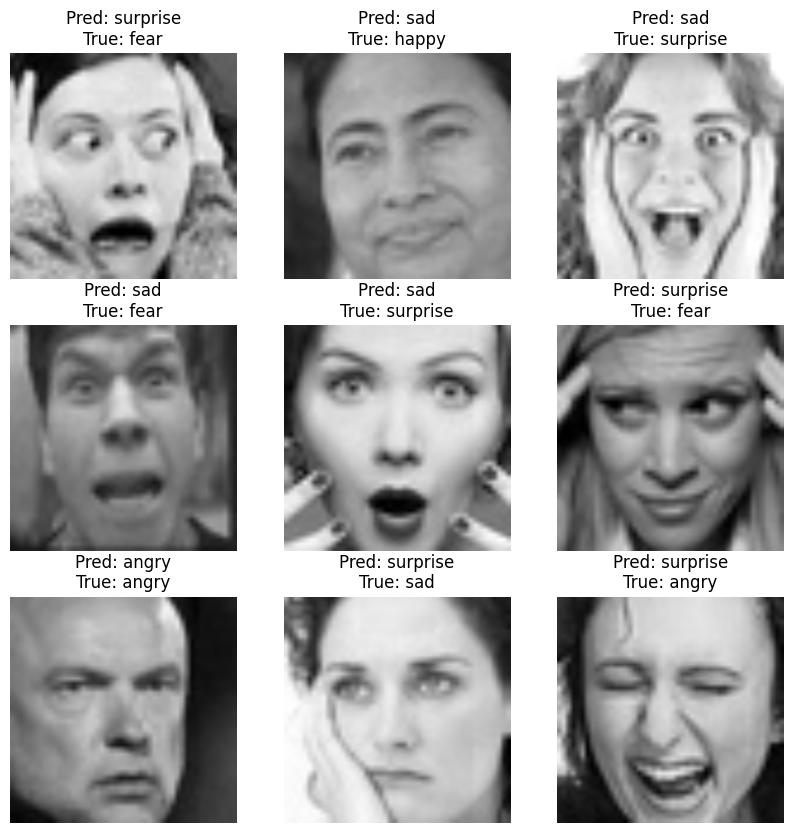

In [46]:
# Visualize predictions
plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):  # Take one batch of test images
    for i in range(9):  # Display 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        predicted_label = Classes[np.argmax(new_model.predict(tf.expand_dims(images[i], axis=0)))]
        true_label = Classes[labels[i].numpy()]
        plt.title(f"Pred: {predicted_label}\nTrue: {true_label}")
        plt.axis("off")
plt.show()

Generate a Classification Report

In [47]:
from sklearn.metrics import classification_report

# Generate classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=Classes))

Classification Report:
              precision    recall  f1-score   support

       angry       0.15      0.11      0.12       779
     disgust       0.00      0.00      0.00        92
        fear       0.00      0.00      0.00       838
       happy       0.67      0.00      0.00      1474
     neutral       0.00      0.00      0.00       986
         sad       0.18      0.29      0.22       977
    surprise       0.09      0.55      0.16       596

    accuracy                           0.12      5742
   macro avg       0.15      0.13      0.07      5742
weighted avg       0.23      0.12      0.07      5742



c:\Users\Auni\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Auni\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Auni\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix

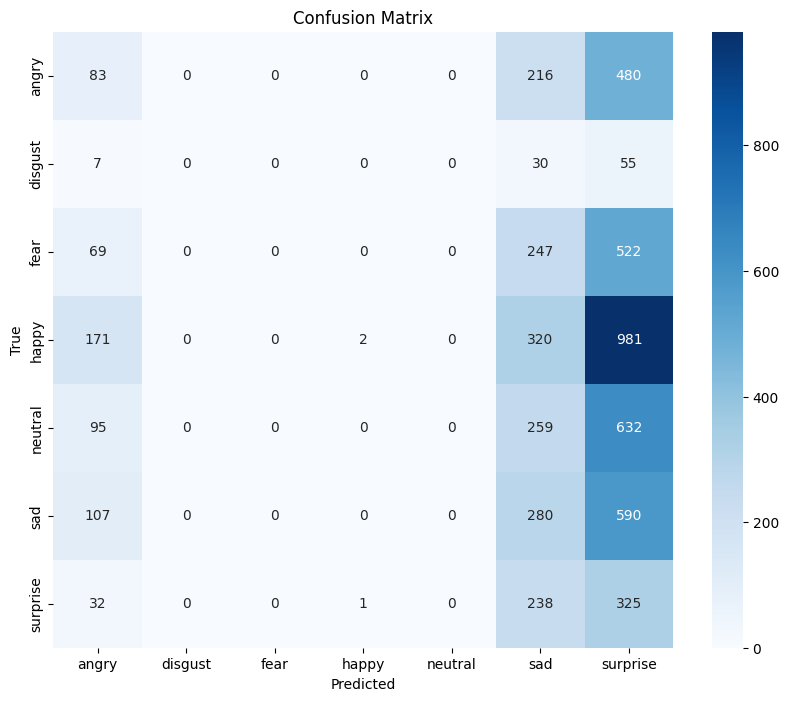

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=Classes, yticklabels=Classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()